In [1]:
import os
import sys
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../")  # for utils
sys.path.append("../section4-N=50k/")  # the appendix is based on the 50k sample training
from util import sns_config, matplot_config, tex_config, Baseline, aggregated_losses_for_model, filter_on_metric

sns.set_style("whitegrid", sns_config)
matplotlib.rcParams.update(matplot_config)

baseline = Baseline(path="../section3-baseline/baseline_k.csv")
df = pd.read_csv("../section4-N=50k/50k_history_v2.csv")
df

,model,dataset,loss,epoch,polarity_mean,semantic_mean
0,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,1,66.541,41.155
1,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,2,67.275,40.589
2,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,3,67.968,40.264
3,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,4,68.594,40.044
4,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,5,68.978,39.852
...,...,...,...,...,...,...
675,gte-base,sst2,TripletLoss,1,87.952,83.035
676,gte-base,sst2,TripletLoss,2,89.278,82.520
677,gte-base,sst2,TripletLoss,3,89.579,82.152
678,gte-base,sst2,TripletLoss,4,90.023,82.005


In [2]:
datasets = df.dataset.unique()
datasets

array(['sarcastic-headlines', 'sst2'], dtype=object)

In [3]:
baseline.baseline_df

,dataset,model,k,p_mean,p_std,s_mean,s_std
2,sst2,gte-base,16,80.376,22.561,83.700,1.436
7,sst2,gte-small,16,77.774,22.204,84.808,1.410
12,sst2,e5-small,16,81.465,23.696,85.516,1.735
17,sst2,minilm-6,16,63.016,21.877,46.594,7.426
22,sarcastic-headlines,gte-base,16,67.402,20.737,81.366,1.641
27,sarcastic-headlines,gte-small,16,66.826,20.573,82.468,1.629
32,sarcastic-headlines,e5-small,16,71.436,21.241,83.404,1.463
37,sarcastic-headlines,minilm-6,16,63.751,20.178,42.307,5.615


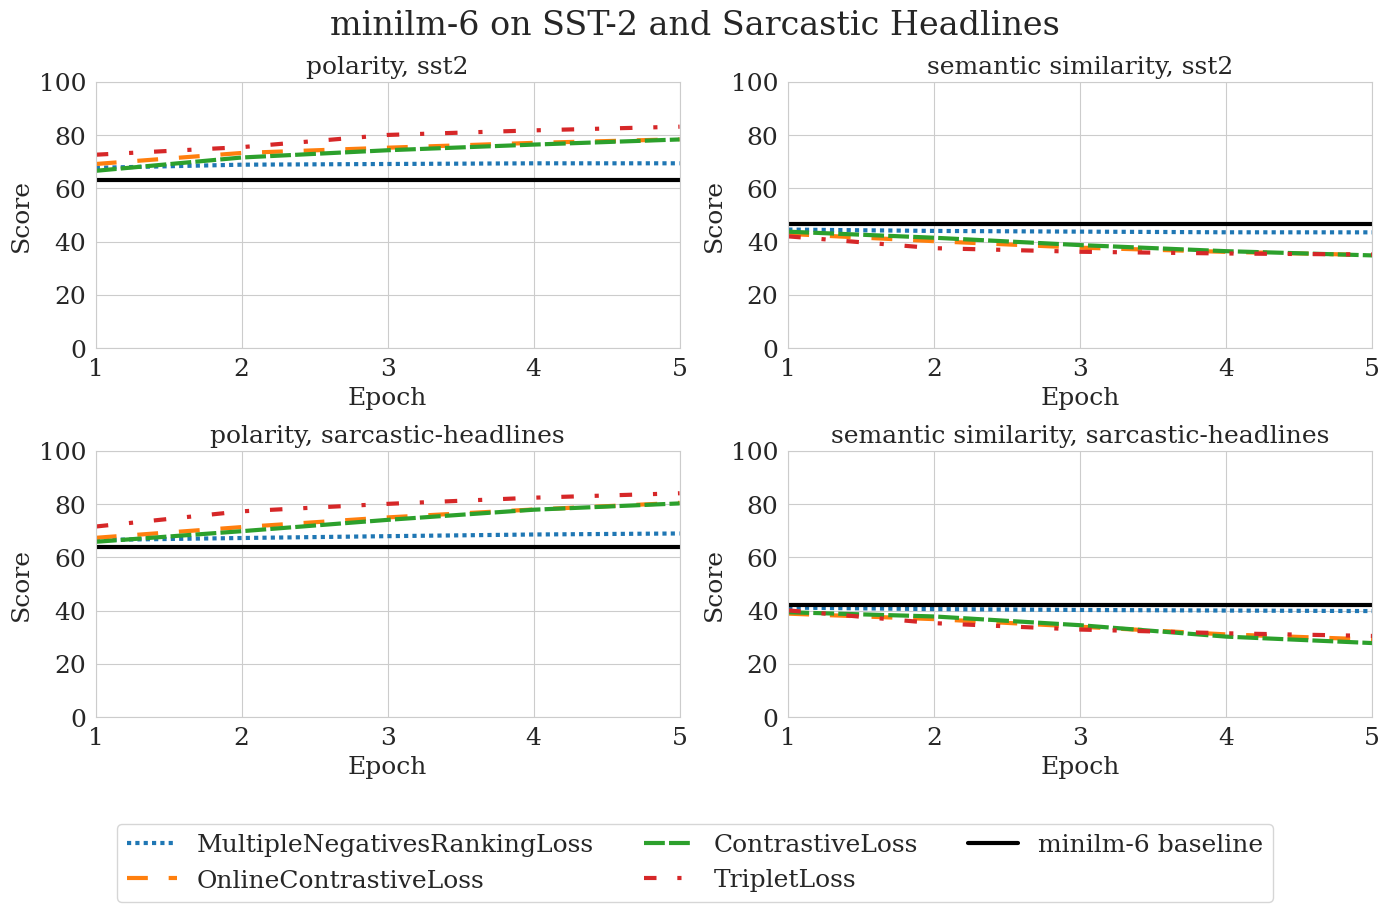

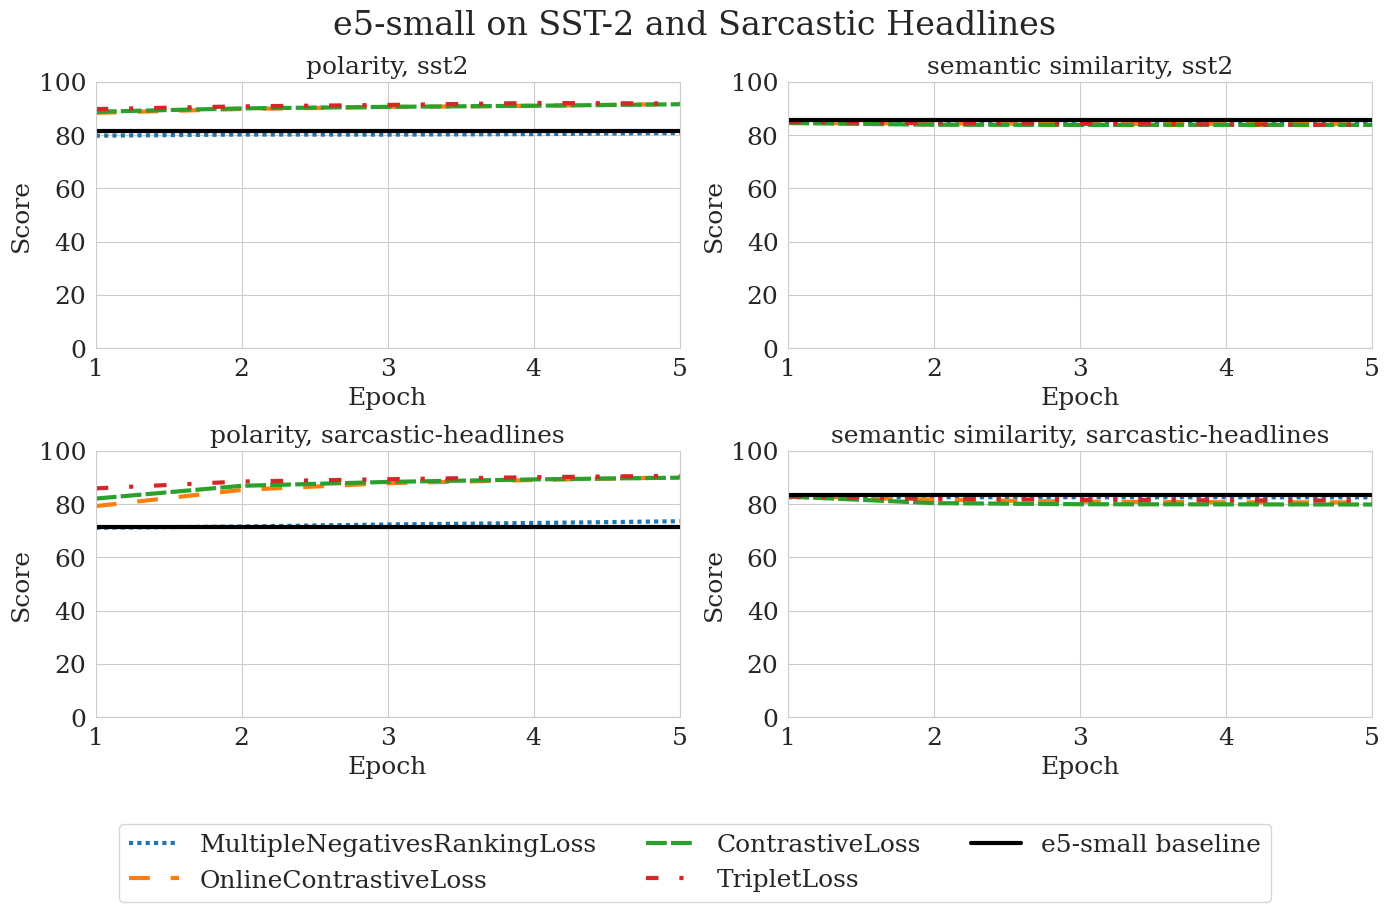

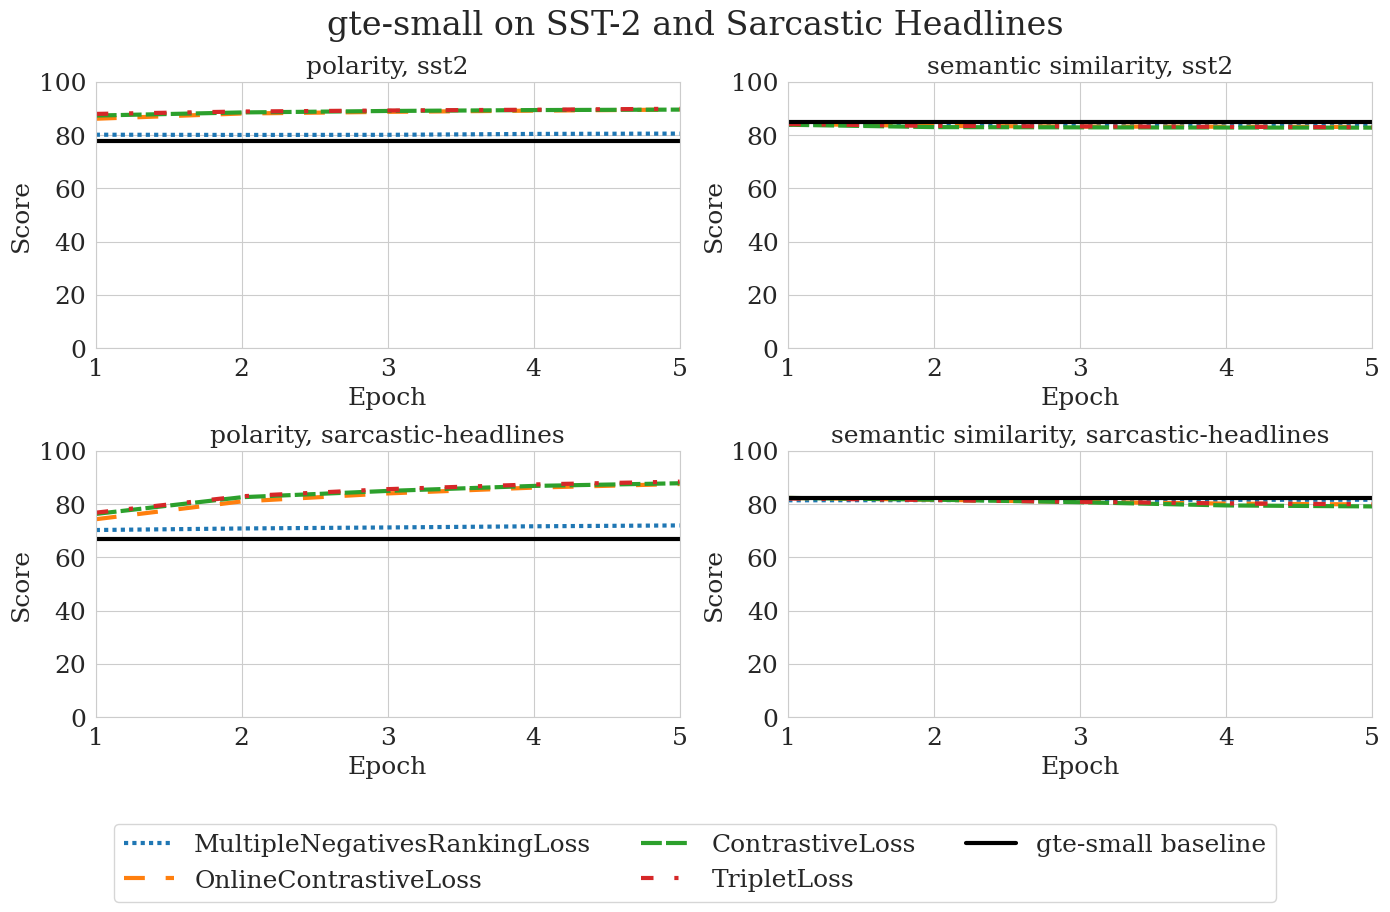

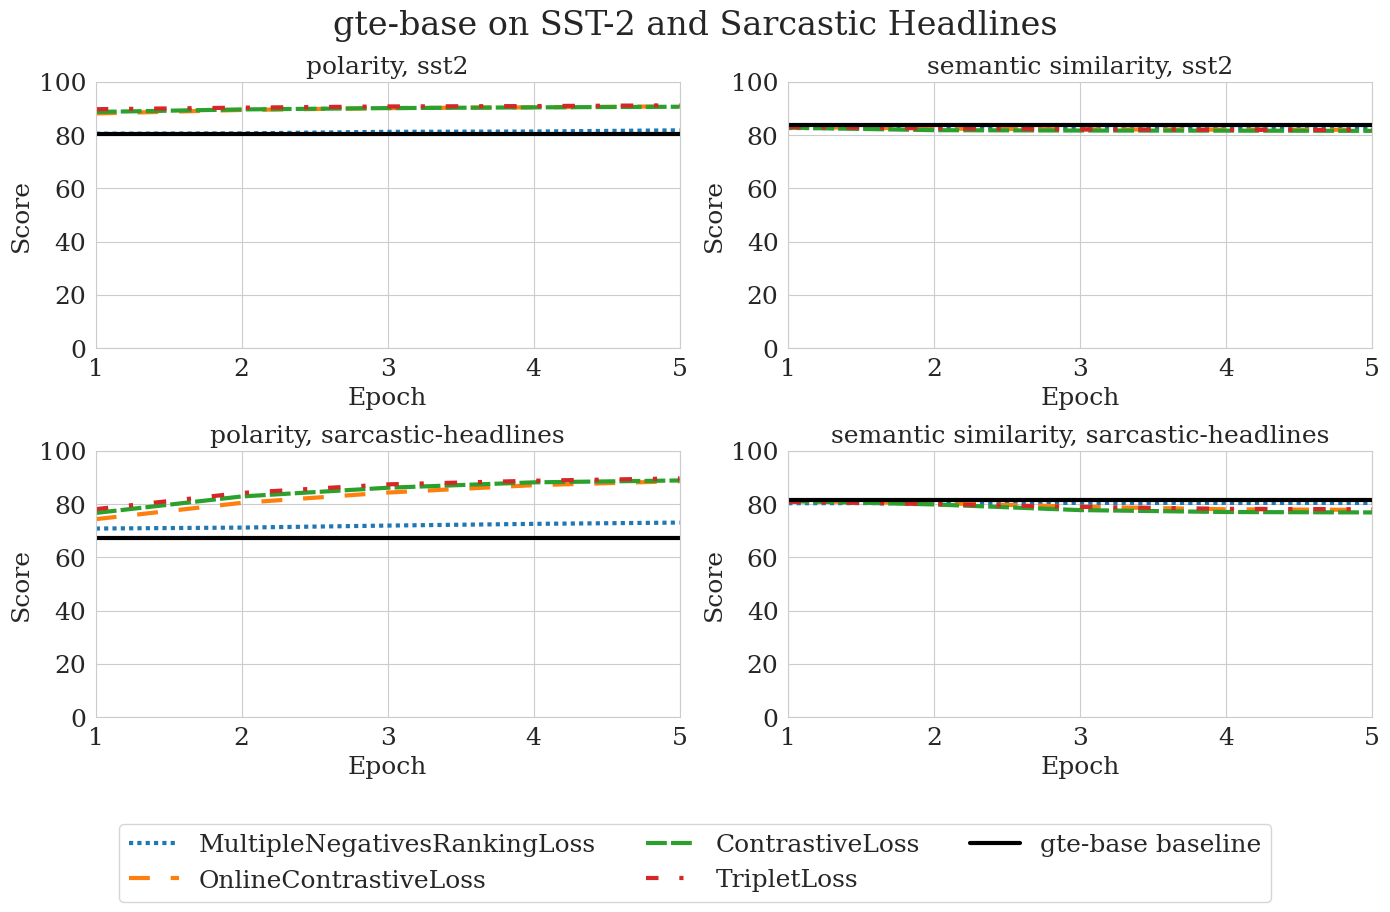

In [4]:
from IPython.display import display

save_latex = False
if save_latex:
    matplotlib.use("pgf")
    matplotlib.rcParams.update(tex_config)

linestyles = [
    (0, (1, 1)),
    (0, (5, 5)),
    (0, (5, 1)),
    (0, (3, 5, 1, 5)),
]

for model in df.model.unique():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    subplot_mapping = {
        ("sst2", "polarity_mean"): axes[0, 0],
        ("sst2", "semantic_mean"): axes[0, 1],
        ("sarcastic-headlines", "polarity_mean"): axes[1, 0],
        ("sarcastic-headlines", "semantic_mean"): axes[1, 1],
    }

    fig.suptitle(f"{model} on SST-2 and Sarcastic Headlines", fontsize=24)

    metrics = ["polarity_mean", "semantic_mean"]
    ylims = [
        (60, 100),
        (30, 100)
    ]
    for metric in metrics:
        _df = df.copy()
        _df = _df[_df.model == model]
        _df = filter_on_metric(_df, metric, to_drop=["polarity_mean", "semantic_mean"])

        # display(_df)

        y_min = min(_df[metric].min(), baseline.get_extremes(model, agg=min, metrics=["p_mean", "s_mean"])) - 0.01
        y_max = max(_df[metric].max(), baseline.get_extremes(model, agg=max, metrics=["p_mean", "s_mean"])) + 0.01
        y_min, y_max = round(y_min, 2), round(y_max, 2)
        
        for dataset in datasets:
            ax = subplot_mapping[(dataset, metric)]
            ax.set_xlim(1, 5)
            ax.set_ylim(0, 100)
            ax.set_title(f"{metric.replace('semantic', 'semantic similarity').split('_')[0]}, {dataset}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Score")
            # set x ticks to 1, 2, 3, 4, 5
            ax.set_xticks(range(1, 6))

            for j, loss in enumerate(_df.loss.unique()):
                __df = _df[(_df.loss == loss) & (_df.dataset == dataset)]
                __df = __df.groupby(["epoch"]).max().reset_index()
                sns.lineplot(data=__df, x="epoch", y=metric, ax=ax, label=loss, legend=False, errorbar=None, linestyle=linestyles[j])
    
            baseline_val = baseline.get(model=model, dataset=dataset, metric="p_mean" if metric == "polarity_mean" else "s_mean")
            if baseline_val:
                ax.plot([1, 5], [baseline_val, baseline_val], linestyle="solid", color="black", alpha=1, linewidth=3, label=f"{model} baseline")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, borderaxespad=-2)
    plt.tight_layout()
    plt.show()
    if save_latex:
        folder = f"figures/model_max_loss"
        os.makedirs(folder, exist_ok=True)
        plt.savefig(f"{folder}/{model}-max-loss.pgf", bbox_inches="tight")